# Car model classification and BBOX generation

In [99]:
### Use this for Google Colab

# from google.colab import drive
# drive.mount('/gdrive')

# Import required libraries

In [4]:
import pandas as pd # Pandas
import numpy as np # Numpy
import tensorflow as tf # Tensorflow
import matplotlib.pyplot as plt # Matplotlib
import matplotlib.image as mpimg # Import image module from matplotlib
import seaborn as sns # Seaborn
import time # Time library
import math # Math library
import datetime, os # Required for tensorboard
import shutil # For killing tensorboard instance
import cv2 # OpenCV Library 
%matplotlib inline

from tensorflow import keras # Import keras
from tensorflow.keras import layers # Import layers from keras
from tensorflow.keras import regularizers # Import regularizers from keras
from tensorflow.keras import models # Import models from keras
from tensorflow.keras import Model # Import Model class from keras
from tensorflow.keras import optimizers # Import optimizers from keras
from tensorflow.keras import losses # Import losses from keras
from tensorflow.keras import metrics # Import metrics from keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img # Import load_img
from tensorflow.keras.preprocessing.image import img_to_array # Import img_to_array

# Import Sequential model
from tensorflow.keras.models import Sequential 
# Import Input, Flatten, Dense, Activation, Conv2D and MaxPooling2D layers
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPooling2D
# Import BatchNormalization and Dropout layers
from tensorflow.keras.layers import BatchNormalization, Dropout

from tensorflow.keras.initializers import HeNormal # He Normal initializer

# Import InverseTimeDecay learning rate scheduler
from tensorflow.keras.optimizers.schedules import InverseTimeDecay 

from tensorflow.keras.callbacks import TensorBoard # Import Tensorboard callback
from tensorflow.keras.callbacks import ModelCheckpoint # Import model checkpoint callback
from tensorflow.keras.callbacks import EarlyStopping # Import early stopping callback
from tensorflow.keras.callbacks import CSVLogger # Import CSV Logger callback
from tensorflow.keras.callbacks import ReduceLROnPlateau # Import ReduceLROnPlateau callback

# Load pre-trained models from keras
from tensorflow.keras.applications import Xception # Import Xception model
from tensorflow.keras.applications import ResNet50 # Import ResNet50 model
from tensorflow.keras.applications import resnet50 # To use for preprocessing function

from tensorflow.keras.utils import to_categorical # Import One-hot encoding function

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

%load_ext tensorboard

# Kill previous instance of Tensorboard if it exists
shutil.rmtree("C:/Users/Suresh Venkatesan/AppData/Local/Temp/.tensorboard-info",\
              ignore_errors = True)

# Define directory paths

In [101]:
### Use this for Google Colab

# # Define base path for TensorBoard Logs directory
# tb_logs_base_dir = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Monkeys_Dataset/TB_logs/"
# os.makedirs(tb_logs_base_dir, exist_ok = True) # Don't raise any exception if directory exists

# # Define base path for storing all outputs related to model / training
# out_base_path = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Model_Outputs/Monkeys_Dataset/Training_Info/"

# # Define base path of dataset
# dataset_path = "/content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Datasets/Image_Datasets/Monkeys_Dataset/"

In [9]:
### Use this for local runs

# Define base path for TensorBoard Logs directory
# tb_logs_base_dir = "C:/User_Directories/logs/Object_Localization/"
# os.makedirs(tb_logs_base_dir, exist_ok = True) # Don't raise any exception if directory exists

# Define base path for storing all outputs related to model / training
# out_base_path = "Model_Info/"

# Define base path of dataset
dataset_path = "Datasets/Temp_Dataset/"

# Import dataset

In [104]:
# Define paths of train and test annotation files
ann_train

# Read train and test annotation csv files as pandas dataframes, csv file has no header
col_names = ['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'label']

train_df_path = os.path.join(dataset_path, 'train.csv')
test_df_path = os.path.join(dataset_path, 'validation.csv')

# Read train.csv file
train_df = pd.read_csv(train_df_path, header = None, names = col_names)
print("Training Set")
print("============")
display(train_df.head())
print()
print()

# Read the validation csv file
test_df = pd.read_csv(test_df_path, header = None, names = col_names)
print("Test Set")
print("========")
display(test_df.head())

Training Set


,File_Name,Height,Width,xmin,ymin,xmax,ymax,Class,Label
0,C:/User_Directories/Sync_With_NAS/Users/suresh...,400,600,333,72,425,158,abyssinian,0
1,C:/User_Directories/Sync_With_NAS/Users/suresh...,500,375,72,105,288,291,abyssinian,0
2,C:/User_Directories/Sync_With_NAS/Users/suresh...,500,394,151,71,335,267,abyssinian,0
3,C:/User_Directories/Sync_With_NAS/Users/suresh...,313,450,54,36,319,235,abyssinian,0
4,C:/User_Directories/Sync_With_NAS/Users/suresh...,465,500,23,27,325,320,abyssinian,0




Test Set


,File_Name,Height,Width,xmin,ymin,xmax,ymax,Class,Label
0,C:/User_Directories/Sync_With_NAS/Users/suresh...,467,400,65,16,243,175,abyssinian,0
1,C:/User_Directories/Sync_With_NAS/Users/suresh...,320,214,48,63,105,117,abyssinian,0
2,C:/User_Directories/Sync_With_NAS/Users/suresh...,400,400,78,12,305,261,abyssinian,0
3,C:/User_Directories/Sync_With_NAS/Users/suresh...,360,263,73,18,184,130,abyssinian,0
4,C:/User_Directories/Sync_With_NAS/Users/suresh...,500,335,135,87,314,285,abyssinian,0


In [105]:
train_df.shape, test_df.shape

((2984, 9), (702, 9))

In [106]:
num_classes_train = len(train_df['Label'].unique()) # Compute number of unique classes in training dataset
num_classes_test = len(test_df['Label'].unique()) # Compute number of unique classes in test dataset
print("Number of unique classes in training dataset is %d" % num_classes_train)
print("Number of unique classes in test dataset is %d" % num_classes_test)

# Create a dictionary to hold label and corresponding class name
label_class_dict = dict(zip(train_df['Label'], train_df['Class']))
display(label_class_dict)

Number of unique classes in training dataset is 37
Number of unique classes in test dataset is 37


{0: 'abyssinian',
 1: 'american_bulldog',
 2: 'american_pit_bull_terrier',
 3: 'basset_hound',
 4: 'beagle',
 5: 'bengal',
 6: 'birman',
 7: 'bombay',
 8: 'boxer',
 9: 'british_shorthair',
 10: 'chihuahua',
 11: 'egyptian_mau',
 12: 'english_cocker_spaniel',
 13: 'english_setter',
 14: 'german_shorthaired',
 15: 'great_pyrenees',
 16: 'havanese',
 17: 'japanese_chin',
 18: 'keeshond',
 19: 'leonberger',
 20: 'maine_coon',
 21: 'miniature_pinscher',
 22: 'newfoundland',
 23: 'persian',
 24: 'pomeranian',
 25: 'pug',
 26: 'ragdoll',
 27: 'russian_blue',
 28: 'saint_bernard',
 29: 'samoyed',
 30: 'scottish_terrier',
 31: 'shiba_inu',
 32: 'siamese',
 33: 'sphynx',
 34: 'staffordshire_bull_terrier',
 35: 'wheaten_terrier',
 36: 'yorkshire_terrier'}

## Visualize Data

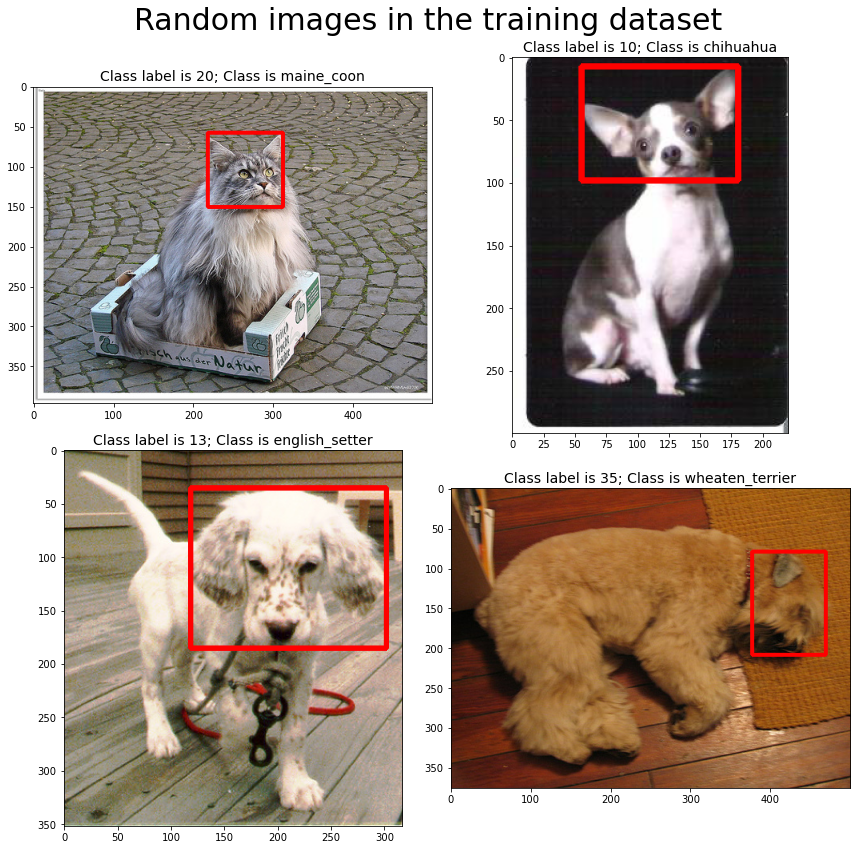

In [107]:
# Plot four random images from training data set along with their class labels and bounding boxes
fig = plt.figure(1, figsize = (12, 12))
fig.suptitle('Random images in the training dataset', fontsize = 30)

# Generate four random sample indices from the training dataset.
samp_index = np.random.randint(low = 0, high = train_df.shape[0], size = 4).tolist()

for ind, value in enumerate(samp_index):
    ax = plt.subplot(2, 2, (ind + 1))
    img = mpimg.imread(train_df.loc[value,'File_Name']) # Read the image file
    xmin = train_df.loc[value, 'xmin'] # xmin co-ordinate of BBOX
    ymin = train_df.loc[value, 'ymin'] # ymin co-ordinate of BBOX
    xmax = train_df.loc[value, 'xmax'] # xmax co-ordinate of BBOX
    ymax = train_df.loc[value, 'ymax'] # ymax co-ordinate of BBOX    
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 4) # Add BBOX around image
    ax.imshow(img)
    ax.set_title("Class label is %d; Class is %s"\
                 %(train_df.loc[value, 'Label'], train_df.loc[value, 'Class']), fontsize = 14)
plt.tight_layout()
plt.show()

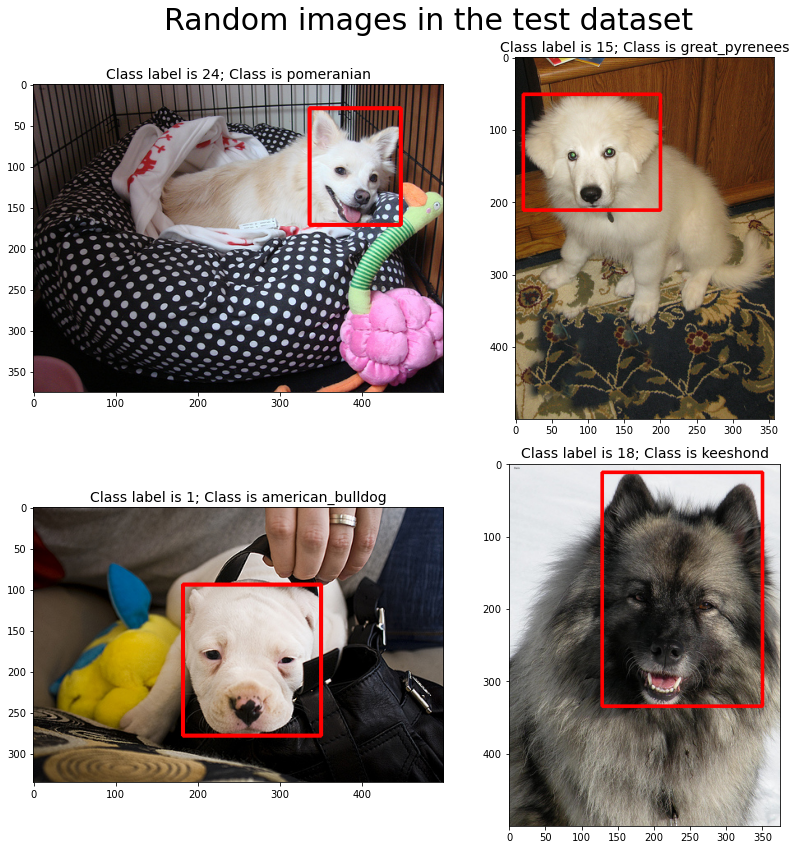

In [108]:
# Plot four random images from test data set along with their class labels and bounding boxes
fig = plt.figure(1, figsize = (12, 12))
fig.suptitle('Random images in the test dataset', fontsize = 30)

# Generate four random sample indices from the test dataset.
samp_index = np.random.randint(low = 0, high = test_df.shape[0], size = 4).tolist()

for ind, value in enumerate(samp_index):
    ax = plt.subplot(2, 2, (ind + 1))
    img = mpimg.imread(test_df.loc[value,'File_Name']) # Read the image file
    xmin = test_df.loc[value, 'xmin'] # xmin co-ordinate of BBOX
    ymin = test_df.loc[value, 'ymin'] # ymin co-ordinate of BBOX
    xmax = test_df.loc[value, 'xmax'] # xmax co-ordinate of BBOX
    ymax = test_df.loc[value, 'ymax'] # ymax co-ordinate of BBOX    
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 4) # Add BBOX around image
    ax.imshow(img)
    ax.set_title("Class label is %d; Class is %s"\
                 %(test_df.loc[value, 'Label'], test_df.loc[value, 'Class']), fontsize = 14)
plt.tight_layout()
plt.show()

# Function: Define a Batch Generator

In [109]:
def batch_generator(df, batch_size = 32, img_size_targ = (224, 224), num_classes_train = 37):
    
    while (True):

        # Create indexes
        image_indexes = np.random.randint(0, df.shape[0], size = batch_size).tolist()

        # Initialize array to store a batch of images
        batch_images = np.zeros(shape = (batch_size, img_size_targ[0], img_size_targ[1], 3))

        # Initialize array to store classification Labels for the above batch of images
        batch_labels = np.zeros(shape = (batch_size, num_classes_train))

        # Initialize array to store bbox co-ordinates for the above batch of images
        # 4 values per image
        batch_bboxes = np.zeros(shape = (batch_size, 4))

        for ind, val in enumerate(image_indexes):

            # Read image, resize and convert to array
            img = load_img(df.loc[val, 'File_Name'], target_size = img_size_targ)
            img_array = img_to_array(img)
            
            # Pre-process image using resnet50.preprocess_input
            img_array = resnet50.preprocess_input(img_array)

            # Read image classification label & convert to one hot vector
            cl_label = df.loc[val, 'Label']
            cl_label = to_categorical(cl_label, num_classes = num_classes_train)

            # Get size and BBOX co-ordinates of original image
            img_width_orig = train_df.loc[val, 'Width'] # Width of original image
            img_height_orig = train_df.loc[val, 'Height'] # Height of original image
            xmin_orig = train_df.loc[val, 'xmin'] # xmin co-ordinate of BBOX in original image
            ymin_orig = train_df.loc[val, 'ymin'] # ymin co-ordinate of BBOX in original image
            xmax_orig = train_df.loc[val, 'xmax'] # xmax co-ordinate of BBOX in original image
            ymax_orig = train_df.loc[val, 'ymax'] # ymax co-ordinate of BBOX in original image

            # Scale BBOX co-ordinates to an image of size (1, 1)
            xmin_norm = (xmin_orig / img_width_orig)
            ymin_norm = (ymin_orig / img_height_orig)
            xmax_norm = (xmax_orig / img_width_orig)
            ymax_norm = (ymax_orig / img_height_orig)
            width_bbox_norm = xmax_norm - xmin_norm
            height_bbox_norm = ymax_norm - ymin_norm
            bbox_sc = [xmin_norm, ymin_norm, width_bbox_norm, height_bbox_norm]

            # Add above image, OHE label and BBOX co-ords to current batch
            batch_images[ind] = img_array
            batch_labels[ind] = cl_label
            batch_bboxes[ind] = bbox_sc

        # Return batch - use yield function to make it a python generator
        yield batch_images, [batch_labels, batch_bboxes]

## Define target image size

In [110]:
img_height_targ, img_width_targ, img_chan_targ = (224, 224, 3)
img_size_targ = (img_height_targ, img_width_targ, img_chan_targ)
img_size_targ

(224, 224, 3)

## Verify batch generator

In [111]:
batch_size = 32
gen = batch_generator(train_df, batch_size = batch_size, img_size_targ = img_size_targ[:2],\
                      num_classes_train = num_classes_train)
print(gen)

<generator object batch_generator at 0x0000015F569A8200>


In [112]:
batch_images, [batch_labels, batch_bboxes] = next(gen)
print("Shape of batch_images is {}" .format(batch_images.shape))
print("Shape of batch_labels is {}" .format(batch_labels.shape))
print("Shape of batch_bboxes is {}" .format(batch_bboxes.shape))

Shape of batch_images is (32, 224, 224, 3)
Shape of batch_labels is (32, 37)
Shape of batch_bboxes is (32, 4)


## Visualize a few images from the batch

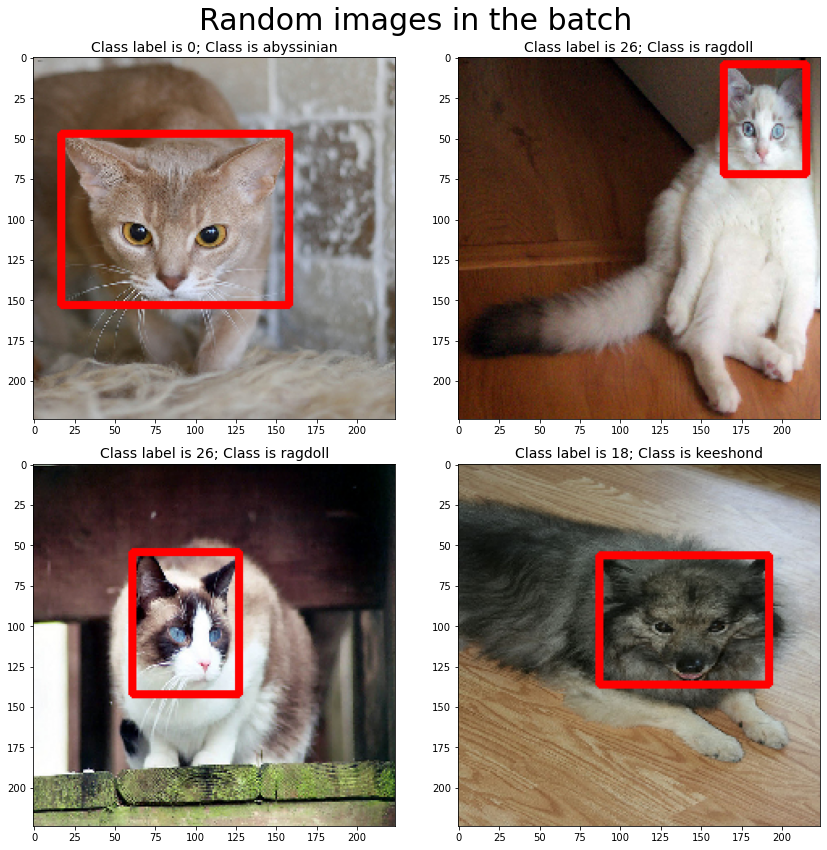

In [113]:
# Plot four random images from the batch along with their class labels and bounding boxes
fig = plt.figure(1, figsize = (12, 12))
fig.suptitle('Random images in the batch', fontsize = 30)

# Generate four random sample indices from the batch.
samp_index = np.random.randint(low = 0, high = batch_size, size = 4).tolist()

for ind, value in enumerate(samp_index):
    ax = plt.subplot(2, 2, (ind + 1))

    # Extract image from batch
    img = batch_images[value].copy()
    # Undo Resnet50 pre-processing
    mean = [103.939, 116.779, 123.68]
    img[..., 0] += mean[0]
    img[..., 1] += mean[1]
    img[..., 2] += mean[2]
    img = img[..., ::-1].astype('uint8')
    
    # Extract image label
    label = np.argmax(batch_labels[value]) 
    
    # Extract bbox co-ordinates
    bbox = batch_bboxes[value]
    xmin_sc = int(bbox[0] * img_size_targ[1])
    ymin_sc = int(bbox[1] * img_size_targ[0])
    xmax_sc = int((bbox[0] + bbox[2]) * img_size_targ[1])
    ymax_sc = int((bbox[1] + bbox[3]) * img_size_targ[0])
    cv2.rectangle(img, (xmin_sc, ymin_sc), (xmax_sc, ymax_sc),\
                  (255, 0, 0), 4) # Add BBOX around image
    
    # Plot image with BBOX
    ax.imshow(img)
    ax.set_title("Class label is %d; Class is %s"\
                 %(label, label_class_dict[label]), fontsize = 14)

plt.tight_layout()
plt.show()

# Build the Model

## Function - Define Model Core

In [114]:
def model_core(model_dict):
    
    """
    Function to define the model core.
    
    Arguments:
    model_dict - Dictionary with list of keys / values needed to build the model
      'model_arch' - Single alphabet string indicating what model architecture to use
      'use_bnorm' - Boolean: If true, use BatchNormalization layer after each hidden layer
      'dropout_rate' - Value of dropout rate to use.
      'resnet_weights' - Set to either None or 'imagenet'
      'resnet_train': Boolean, If True, train ResNet50 weights also.

    Returns:
    model - Model with all layers instantiated
 
    """    
    # Retrieve model dict parameters
    model_arch = model_dict['model_arch']

    ##### Start Model Architecture A
    if (model_arch == 'A'):
        # Retrieve arch. specific model dict parameters
        resnet_weights = model_dict['resnet_weights']
        resnet_train = model_dict['resnet_train']
        dropout_rate = model_dict['dropout_rate']
        num_classes = model_dict['num_classes']
        
        base_model = ResNet50(weights = resnet_weights, input_shape = img_size_targ,\
                              pooling = 'avg', include_top = False)
        for layer in base_model.layers:
            layer.trainable = False
            
        # Retrieve output of pre-trained model
        X = base_model.output
        # Add Dropout
        X = Dropout(rate = dropout_rate[0], name = 'DR0')(X)
        # Add one Dense layer
        X = Dense(200, activation = 'relu')(X)
        # Add Batch Norm layer
        X = BatchNormalization()(X)  
        # Add output layer for label classification
        label_output = Dense(num_classes, activation = 'softmax', name = 'class_op')(X)        
        # Add output layer for bounding box regression
        bbox_output = Dense(4, activation = 'sigmoid', name = 'reg_op')(X)        
        
        # Define overall model
        model = Model(inputs = base_model.input, outputs = [label_output, bbox_output])
        
    ##### End Model Architecture A    

    return model

In [115]:
# Verify model defined above
model_dict = {'model_arch': 'A',
              'resnet_weights': 'imagenet',
              'resnet_train': False, 
              'dropout_rate': [0.5],
              'num_classes': num_classes_train
              }
temp_model = model_core(model_dict)
temp_model.output

[<KerasTensor: shape=(None, 37) dtype=float32 (created by layer 'class_op')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'reg_op')>]

## Function - Define model compile, train and eval

In [123]:
def model_comp_fit_eval(model_dict, train_dict):
    
    """
    Function to compile, fit and evaluate model. Use this function to start fitting a
    model from initial randomized weights. For continuing an already fitted model, use
    function model_fit_cont
    
    Arguments:
    model_dict - Dictionary with list of keys / values needed to build the model
               - See function model_core for more details
    train_dict - Dictionary with list of keys / values needed to compile and train the model
      'epochs': Number of epochs to train for
      'steps_per_epoch': Number of steps per epoch
      'val_steps': Number of steps before stopping validation
      'early_stop': Boolean: If True, implement early stop
      'redlr_plat': Boolean: If True, implement reduce learning rate plateau      
      'ilr': Initial learning rate to use for learning rate decay scheduler
      'dr': Decay rate to use for learning rate decay scheduler
      'ds': Decay step to use for learning rate decay scheduler
      'lrpl_fac': Factor to use for Reduce LR on Plateau callback
      'lrpl_pat': Patience to use for Reduce LR on Plateau callback
      'verb': Boolean: If True, print running summary during model fit.
      'tb_path': Path to store Tensorboard callback information
      'bm_path': File name to use for storing best model checkpoint
      'fm_path': File name to use for storing final trained model
      'hi_path': File name to use for storing training history

    Returns:
    model - Model instance with trained weights
    hist - Training history object 

    """      
    # Retrieve train_dict parameters
    epochs = train_dict['epochs'] # Number of epochs to train for
    steps_per_epoch = train_dict['steps_per_epoch'] # Number of steps per epoch
    val_steps = train_dict['val_steps'] # Number of steps before stopping validation
    early_stop = train_dict['early_stop'] # Boolean: If True, implement early stop
    ilr = train_dict['ilr'] # Initial learning rate to use for learning rate decay scheduler
    redlr_plat = train_dict['redlr_plat'] # Boolean: If True, implement reduce learning rate plateau    
    dr = train_dict['dr'] # Decay rate to use for learning rate decay scheduler
    ds = train_dict['ds'] # Decay step to use for learning rate decay scheduler
    lrpl_fac = train_dict['lrpl_fac'] # Factor to use for Reduce LR on Plateau callback
    lrpl_pat = train_dict['lrpl_pat'] # Patience to use for Reduce LR on Plateau callback    
    verb = train_dict['verb'] # Boolean: If True, print running summary during model fit.
    tb_path = train_dict['tb_path'] # Path to store Tensorboard callback information
    bm_path = train_dict['bm_path'] # File name to use for storing best model checkpoint
    fm_path = train_dict['fm_path'] # File name to use for storing final trained model
    hi_path = train_dict['hi_path'] # File name to use for storing training history

    # Instantiate model
    model = model_core(model_dict)
    
    # Define learning rate decay schedule
    lr_sch = InverseTimeDecay(ilr, ds, dr)
    # Define Optimizer
    if (redlr_plat):
      opt = optimizers.Adam(learning_rate = ilr) 
    else:
      opt = optimizers.Adam(learning_rate = lr_sch)
    # Define Loss:
    # - CategoricalCrossEntropy for 'class_op' 
    # - MeanSquaredError for 'reg_op'
    loss_dict = {'reg_op': losses.MeanSquaredError(),
                 'class_op': losses.CategoricalCrossentropy()
                }
    loss_weights_dict = {'reg_op': 1,
                        'class_op': 1
                       }
    
    # Define Metric = Categorical Accuracy
    met = metrics.Accuracy()

    # Compile model
    model.compile(optimizer = opt, loss = loss_dict, loss_weights = loss_weights_dict,\
                  metrics = met)
    
    # Define path for tensorboard logs
    logdir = os.path.join(tb_path, datetime.datetime.now().strftime("%d_%H_%M_%S"))
    # Define Tensorboard callback
    tensorboard_callback = TensorBoard(logdir, histogram_freq = 0)
    
    # Define Model Checkpoint callback
    mcp_callback = ModelCheckpoint(filepath = bm_path, monitor = "val_loss", save_best_only = True,\
                                   save_weights_only = False, mode = "min", save_freq = "epoch")

    # Define Early Stopping callback
    earlystopping_callback = EarlyStopping(monitor = "loss", min_delta = 1e-4, patience = 10,\
                                           mode = "min", verbose = 1)
    
    # Define 'Reduce learning rate on plateau' callback
    redlr_plat_callback = ReduceLROnPlateau(monitor = "val_loss", factor = lrpl_fac, patience = lrpl_pat,\
                                            verbose = 1, mode = "min", min_delta = 0.0001)

    # Define list of all callbacks
    callback_list = []
    if (redlr_plat):
      callback_list.append(redlr_plat_callback)
    if (early_stop):
      callback_list.append(earlystopping_callback)
    if (tb_path != 'None'):
      callback_list.append(tensorboard_callback)
    if (bm_path != 'None'):
      callback_list.append(mcp_callback)

    # Fit model
    hist = model.fit(x = train_generator, epochs = epochs, steps_per_epoch = steps_per_epoch,\
                     validation_data = test_generator, validation_steps = val_steps,\
                     verbose = verb, callbacks = callback_list)
        
    # Save final trained model to file
    if (fm_path != 'None'):
      # Save final trained model in Keras HDF5 format
      model.save(fm_path, overwrite = True, save_format = 'h5') 
    if (hi_path != 'None'):
      # Save training history to file
      np.save(hi_path, hist.history)
    
    return model, hist

## Launch Tensorboard

In [117]:
# %tensorboard --logdir {tb_logs_base_dir}
# %tensorboard --logdir {tb_logs_base_dir}

## Define train and test generators

In [119]:
# Create train and test generator
batch_size = 64
train_generator = batch_generator(train_df, batch_size = batch_size,\
                                  img_size_targ = img_size_targ[:2],\
                                  num_classes_train = num_classes_train)
test_generator = batch_generator(test_df, batch_size = batch_size,\
                                  img_size_targ = img_size_targ[:2],\
                                  num_classes_train = num_classes_test)

## Set all model, compile and training parameters

In [120]:
### Define file paths
# Prefix to use for naming files and paths
mod_file_pref = "MA_1A" 
# Tensorboard base path
tb_path = os.path.join(tb_logs_base_dir, mod_file_pref) 
# Path for storing final trained model
fm_path = os.path.join(out_base_path, mod_file_pref + "_finalmodel.h5") 
# Path for storing best model (model with lowest validation set loss)
bm_path = os.path.join(out_base_path, mod_file_pref + "_bestmodel.h5")
# Path for storing training history
hi_path = os.path.join(out_base_path, mod_file_pref + "_hist.npy")

# Define model_dict and train_dict
model_dict = {'model_arch': 'A',
              'resnet_weights': 'imagenet',
              'resnet_train': False, 
              'dropout_rate': [0.5],
              'num_classes': num_classes_train
              }
train_dict = {'epochs': 10, # Number of epochs to train for
              'initial_epoch': 0, # Initial epoch to start from
              'fit_resume': False, # Boolean: If True, resume fit from initial epoch
              'steps_per_epoch': (train_df.shape[0] // batch_size), # No. of steps per epoch
              'val_steps': (test_df.shape[0] // batch_size), # No. of steps before stopping val
              'early_stop': False, # Boolean: If True, implement early stop
              'redlr_plat': False, # Boolean: If True, implement reduce learning rate plateau
              'ilr': 0.001, # Initial learning rate to use for learning rate decay scheduler
              'dr': 0, # Decay rate to use for learning rate decay scheduler
              'ds': ((train_df.shape[0] // batch_size) * 10), # Decay step to use for lr decay
              'lrpl_fac': 0.5, # Factor to use for Reduce LR on Plateau callback
              'lrpl_pat': 10, # Patience to use for Reduce LR on Plateau callback              
              'verb': 0, # Boolean: If True, print running summary during model fit.
              'tb_path': tb_path, # Path to store Tensorboard callback information
              'bm_path': bm_path, # File name to use for storing best model checkpoint
              'fm_path': fm_path, # File name to use for storing final trained model
              'hi_path': hi_path, # File name to use for storing training history
              }
print(tb_path)
print(bm_path)
print(fm_path)
print(hi_path)

C:/User_Directories/logs/Object_Localization/MA_1A
Model_Info/MA_1A_bestmodel.h5
Model_Info/MA_1A_finalmodel.h5
Model_Info/MA_1A_hist.npy


In [124]:
# Verify model instantiation, loss and compile options
train_dict_temp = {'epochs': 2, # Number of epochs to train for
              'initial_epoch': 0, # Initial epoch to start from
              'fit_resume': False, # Boolean: If True, resume fit from initial epoch
              'steps_per_epoch': (train_df.shape[0] // batch_size), # No. of steps per epoch
              'val_steps': (test_df.shape[0] // batch_size), # No. of steps before stopping val
              'early_stop': False, # Boolean: If True, implement early stop
              'redlr_plat': False, # Boolean: If True, implement reduce learning rate plateau
              'ilr': 0.001, # Initial learning rate to use for learning rate decay scheduler
              'dr': 0, # Decay rate to use for learning rate decay scheduler
              'ds': ((train_df.shape[0] // batch_size) * 10), # Decay step to use for lr decay
              'lrpl_fac': 0.5, # Factor to use for Reduce LR on Plateau callback
              'lrpl_pat': 10, # Patience to use for Reduce LR on Plateau callback              
              'verb': 1, # Boolean: If True, print running summary during model fit.
              'tb_path': 'None', # Path to store Tensorboard callback information
              'bm_path': 'None', # File name to use for storing best model checkpoint
              'fm_path': 'None', # File name to use for storing final trained model
              'hi_path': 'None', # File name to use for storing training history
              }

if (train_dict_temp['fit_resume']):
  temp_model, _ = model_fit_cont(temp_model, train_dict_temp)
else:
  temp_model, _ = model_comp_fit_eval(model_dict, train_dict_temp)  

display(temp_model.loss)
print()
display(temp_model.optimizer.get_config())
print()
display(temp_model.summary())

Epoch 1/2
46/46 [==============================] - 507s 11s/step - loss: 2.8035 - class_op_loss: 2.6772 - reg_op_loss: 0.1263 - class_op_accuracy: 0.0000e+00 - reg_op_accuracy: 0.0000e+00 - val_loss: 0.8069 - val_class_op_loss: 0.6805 - val_reg_op_loss: 0.1264 - val_class_op_accuracy: 0.0000e+00 - val_reg_op_accuracy: 0.0000e+00
Epoch 2/2
46/46 [==============================] - 672s 15s/step - loss: 0.6514 - class_op_loss: 0.5742 - reg_op_loss: 0.0771 - class_op_accuracy: 0.0000e+00 - reg_op_accuracy: 0.0000e+00 - val_loss: 0.5748 - val_class_op_loss: 0.4993 - val_reg_op_loss: 0.0754 - val_class_op_accuracy: 0.0000e+00 - val_reg_op_accuracy: 0.0000e+00


{'reg_op': <tensorflow.python.keras.losses.MeanSquaredError at 0x15f5196ba30>,
 'class_op': <tensorflow.python.keras.losses.CategoricalCrossentropy at 0x15f5196b3a0>}

{'name': 'Adam',
 'learning_rate': {'class_name': 'InverseTimeDecay',
  'config': {'initial_learning_rate': 0.001,
   'decay_steps': 460,
   'decay_rate': 0,
   'staircase': False,
   'name': None}},
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

None

# Backup

Define function to calculate IoU

In [ ]:
def calculate_iou(y_true, y_pred):
    
    
    """
    Input:
    Keras provides the input as numpy arrays with shape (batch_size, num_columns).
    
    Arguments:
    y_true -- first box, numpy array with format [x, y, width, height, conf_score]
    y_pred -- second box, numpy array with format [x, y, width, height, conf_score]
    x any y are the coordinates of the top left corner of each box.
    
    Output: IoU of type float32. (This is a ratio. Max is 1. Min is 0.)
    
    """

    
    results = []
    
    for i in range(0,y_true.shape[0]):
    
        # set the types so we are sure what type we are using
        y_true = np.array(y_true, dtype=np.float32)
        y_pred = np.array(y_pred, dtype=np.float32)

        #print(y_true.shape)
        #print(y_pred.shape)
        # boxTrue
        x_boxTrue_tleft = y_true[i,0]  # numpy index selection
        y_boxTrue_tleft = y_true[i,1]
        boxTrue_width = y_true[i,2]
        boxTrue_height = y_true[i,3]
        area_boxTrue = (boxTrue_width * boxTrue_height)

        # boxPred
        x_boxPred_tleft = y_pred[i,0]
        y_boxPred_tleft = y_pred[i,1]
        boxPred_width = y_pred[i,2]
        boxPred_height = y_pred[i,3]
        area_boxPred = (boxPred_width * boxPred_height)

        # calculate the bottom right coordinates for boxTrue and boxPred

        # boxTrue
        x_boxTrue_br = x_boxTrue_tleft + boxTrue_width
        y_boxTrue_br = y_boxTrue_tleft + boxTrue_height # Version 2 revision

        # boxPred
        x_boxPred_br = x_boxPred_tleft + boxPred_width
        y_boxPred_br = y_boxPred_tleft + boxPred_height # Version 2 revision


        # calculate the top left and bottom right coordinates for the intersection box, boxInt

        # boxInt - top left coords
        x_boxInt_tleft = np.max([x_boxTrue_tleft,x_boxPred_tleft])
        y_boxInt_tleft = np.max([y_boxTrue_tleft,y_boxPred_tleft]) # Version 2 revision

        # boxInt - bottom right coords
        x_boxInt_br = np.min([x_boxTrue_br,x_boxPred_br])
        y_boxInt_br = np.min([y_boxTrue_br,y_boxPred_br]) 

        # Calculate the area of boxInt, i.e. the area of the intersection 
        # between boxTrue and boxPred.
        # The np.max() function forces the intersection area to 0 if the boxes don't overlap.
        
        
        # Version 2 revision
        area_of_intersection = \
        np.max([0,(x_boxInt_br - x_boxInt_tleft)]) * np.max([0,(y_boxInt_br - y_boxInt_tleft)])

        iou = area_of_intersection / ((area_boxTrue + area_boxPred) - area_of_intersection)


        # This must match the type used in py_func
        iou = np.array(iou, dtype=np.float32)
        
        # append the result to a list at the end of each loop
        results.append(iou)
    
    # return the mean IoU score for the batch
    return np.mean(results)



def IoU(y_true, y_pred):
    
    # Note: the type float32 is very important. It must be the same type as the output from
    # the python function above or you too may spend many late night hours 
    # trying to debug and almost give up.
    
    iou = tf.py_function(calculate_iou, [y_true, y_pred], tf.float32)

    return iou

Train the model

In [ ]:
final_model.compile(optimizer='adam', 
                    loss={'reg_op':'mse', 'class_op':'categorical_crossentropy'},
                    loss_weights={'reg_op':20, 'class_op':1},
                    metrics={'reg_op':[IoU], 'class_op':['accuracy']})

## Model Prediction

In [ ]:
def predict_and_draw(image_num, df):

    #Load image
    img = tf.keras.preprocessing.image.load_img(df.loc[image_num, 'File'])
    w, h = img.size

    #Prepare input for model
    #1. Resize image
    img_resized = img.resize((img_size, img_size))
    #2. Conver to array and make it a batch of 1
    input_array = tf.keras.preprocessing.image.img_to_array(img_resized)
    input_array = np.expand_dims(input_array, axis=0)

    #3. Normalize image data
    input_array = tf.keras.applications.resnet50.preprocess_input(input_array)

    #Prediction
    pred = final_model.predict(input_array)
    #Get classification and regression predictions
    label_pred, bbox_pred = pred[0][0], pred[1][0]
    #Get Label with highest probability
    pred_class = label_class_dict[np.argmax(label_pred)]

    #Read actual label and bounding box
    act_class = df.loc[image_num, 'Class']
    xmin, ymin, xmax, ymax = df.loc[image_num, ['xmin', 'ymin', 'xmax', 'ymax']]

    print('Real Label :', act_class, '\nPredicted Label: ', pred_class)
    
    #Draw bounding boxes - Actual (Red) and Predicted(Green)
    img = cv2.imread(df.loc[image_num, 'File'])
    
    #Draw actual bounding box
    img = cv2.rectangle(img, (xmin, ymin), 
                        (xmax, ymax), (0,0,255), 3)
    
    #Draw predicted bounding box
    img = cv2.rectangle(img, (int(bbox_pred[0]*w), int(bbox_pred[1]*h)), 
                        (int((bbox_pred[0]+bbox_pred[2])*w), int((bbox_pred[1]+bbox_pred[3])*h)), (0,255,0), 3)

    #Display the picture
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [ ]:
#Predict on Test Dataset
image_num = np.random.randint(0, test_df.shape[0])
predict_and_draw(image_num, test_df)

In [ ]:
img = tf.keras.preprocessing.image.load_img(test_df.loc[image_num, 'File'], target_size=(224,224))
img_array = tf.keras.preprocessing.image.img_to_array(img)

In [ ]:
img_array.shape

In [ ]:
final_model.input

In [ ]:
np.expand_dims(img_array, axis=0).shape

In [ ]:
final_model.predict(np.expand_dims(img_array, axis=0))